[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/tut6_LSTM_teacher.ipynb)

# Exercise LSTM time series forecasting
In this exercise, we will illustrate the deficiencies of feedforward networks when the data is time-dependent (time series data). Time series or sequence data come in Rank-3 tensor, i.e. `(batch, timesteps, features)`. You will see how recurrent neural networks can overcome these deficiencies. We simulate a very simple time series, and your task will be to fit a feedforward network and an LSTM and compare their predictions. 

When fitting a model to time series data, you must choose the time lag order. Here we keep things simple and choose a lag order of 1. This means we build models which predict $y_{t}$ based on the feature $y_{t-1}$.

You can use the demo notebooks in [demos/rnn](https://github.com/Humboldt-WI/adams/tree/master/demos/rnn) to see further details on how to fit LSTMs.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import keras
from tensorflow.keras import layers

In [2]:
## Simulate time series
time_window = np.arange(120)
ts = np.sin(time_window)

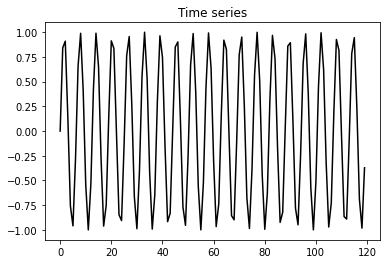

In [3]:
## Plot time series
plt.plot(time_window, ts, color = 'black')
plt.title('Time series')
plt.show()

## Exercise 1
Transform the time series data `ts` into a target 
$$y=\left(\begin{array}{cc} 
y_{1} \\
y_{2}  \\
\vdots  \\
y_{t-1} \\
y_{t} 
\end{array}\right)
$$ 
and a feature matrix (with only one column) 
$$X=\left(\begin{array}{cc} 
y_{0}\\
y_{1} \\
\vdots \\
y_{t-2}\\
y_{t-1}
\end{array}\right)
$$
Choose the first 80 observations as training data, the next 20 as validation and the remaining observations as test data. Use the function `create_dataset`, provided below.

In [4]:
## prepare data for model building
def create_dataset(time_series, window_size):
    """ Function to create data set with lagged response values for estimating an autoregressive model"""
    dataX, dataY = [], []
    
    for i in range(0,len(time_series) - window_size):
        x = np.reshape(time_series[i:i + window_size],(-1,1)) # Remember: x[a:b-1]
        dataX.append(x)
        y = time_series[i + window_size] # Remember: x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

## Create data set and split in training and test
X_matrix, y  = create_dataset(ts, 1)
# Training set
X_train = X_matrix[:80]
Y_train = y[:80]
# Validation set
X_val = X_matrix[80:100]
Y_val = y[80:100]
# Test set
X_test = X_matrix[100:]
Y_test = y[100:]

In [5]:
## Examine data
np.c_[y,X_matrix[:,0,0]][:10]

array([[ 0.84147098,  0.        ],
       [ 0.90929743,  0.84147098],
       [ 0.14112001,  0.90929743],
       [-0.7568025 ,  0.14112001],
       [-0.95892427, -0.7568025 ],
       [-0.2794155 , -0.95892427],
       [ 0.6569866 , -0.2794155 ],
       [ 0.98935825,  0.6569866 ],
       [ 0.41211849,  0.98935825],
       [-0.54402111,  0.41211849]])

## Using `timeseries_dataset_from_array()`, a built-in utility in Keras
Alternatively, we can prepare the dataset in the following way

In [6]:
seq_len = 1
dd = keras.preprocessing.timeseries_dataset_from_array(
    data = np.reshape(ts[:-seq_len],(-1,1)), # The features corresponds to obs [0,n-1]
    targets=ts[seq_len:], # The target corresponds to obs [1,n]
    sequence_length=seq_len, # The lag order
    batch_size=1
)

2022-06-10 14:15:45.154688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Have a look to the first 10 samples
for inputs, targets in dd.take(10):
    for i in range(inputs.shape[0]):
        print(targets[i].numpy(), [x.numpy() for x in inputs[i]])

0.8414709848078965 [array([0.])]
0.9092974268256817 [array([0.84147098])]
0.1411200080598672 [array([0.90929743])]
-0.7568024953079282 [array([0.14112001])]
-0.9589242746631385 [array([-0.7568025])]
-0.27941549819892586 [array([-0.95892427])]
0.6569865987187891 [array([-0.2794155])]
0.9893582466233818 [array([0.6569866])]
0.4121184852417566 [array([0.98935825])]
-0.5440211108893699 [array([0.41211849])]


In [10]:
# Check that the shapes for the inputs are (batch_size, timesteps, input_features) and
# targets (batch_size, )
for inputs, targets in dd:
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)
    break

Inputs shape: (1, 1, 1)
Targets shape: (1,)


## Exercise 2
Fit a feedforward network of your choice and make predictions on the training and test set. Plot the predictions in comparison to the time series `y`.

In [11]:
# Create feedforward neural network
seq_len = X_train.shape[-2] # the timestep, in our case is 1
num_features = X_train.shape[-1] # in our case is also 1

# Using the functional API
inputs = keras.Input(shape = (seq_len, num_features)) # (timesteps, input_features)
x = layers.Flatten()(inputs) # flat the dims of timesteps and input features 
x = layers.Dense(5, activation = "relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

# Using the Sequential model v1
# model = keras.Sequential([
#     layers.Flatten(),
#     layers.Dense(5, activation="relu"),
#     layers.Dense(1)
# ])

# Using the Sequential model v2
# model = keras.Sequential()
# model.add(layers.Flatten())
# model.add(layers.Dense(5, activation="relu")) 
# model.add(layers.Dense(1)) 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit the model and make predictions for train and test sets
model.compile(optimizer='rmsprop', 
    loss='mse', 
    metrics=['mae']) 
    
history = model.fit(
    X_train, 
    Y_train, 
    epochs = 100, 
    batch_size=1,
    validation_data=(X_val, Y_val),
    verbose = 0) 

## make predictions
pred_ff_train = model.predict(X_train)
pred_ff_test = model.predict(X_test)

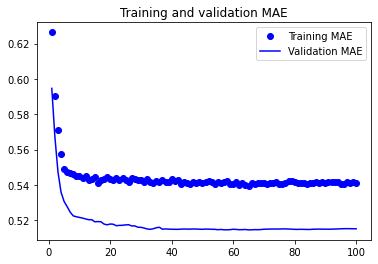

In [13]:
## Plot fitting history
loss = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

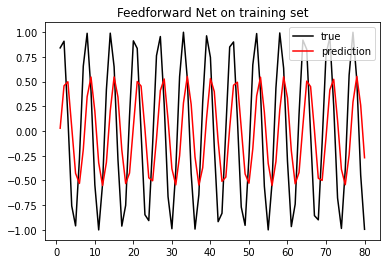

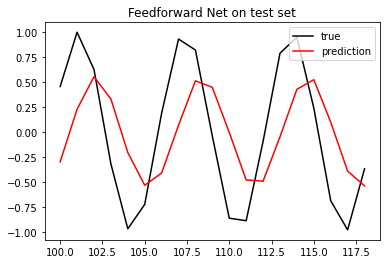

In [14]:
## Plot predictions on traning set
plt.plot(range(1,X_train.shape[0]+1), Y_train, color = 'black', label = 'true')
plt.plot(range(1,X_train.shape[0]+1), pred_ff_train, color = 'red', label = 'prediction')
plt.title('Feedforward Net on training set')
plt.legend()
plt.show()

## Plot predictions on test set
plt.plot(range(100,X_test.shape[0]+100), Y_test, color = 'black', label = 'true')
plt.plot(range(100,X_test.shape[0]+100), pred_ff_test, color = 'red', label = 'prediction')
plt.title('Feedforward Net on test set')
plt.legend()
plt.show()


## Note on RNN
Before diving into RNN, let's understand what an RNN does in one forward pass. We are going to implement a one forward pass of `SimpleRNN` in `Numpy` where the output is just $$o_t=\tanh(W\cdot i_t + U \cdot  s_{t-1} +b)$$


In [15]:
# Assign random weights to W, U and b
timesteps = 1
input_dim = 1
n_units = 5
inputs = np.random.random((timesteps, input_dim)) 
state_t = np.zeros((n_units,))
W = np.random.random((n_units, input_dim)) 
U = np.random.random((n_units, n_units)) 
b = np.random.random((n_units,)) 

In [16]:
outputs_tot = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    outputs_tot.append(output_t)
    state_t = output_t
output_final = np.stack(outputs_tot, axis=0)
output_final.shape

(1, 5)

Let's implement this simple RNN to our prediction problem

### Stateless mode

In [17]:
# Simple model
inputs = keras.Input(batch_shape=(1,1,1))
x = layers.SimpleRNN(5)(inputs) 
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(1, 1, 1)]               0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (1, 5)                    35        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fit the model
model.compile(optimizer='rmsprop', 
    loss='mse', 
    metrics=['mae']) 
    
model.fit(    
    X_train, 
    Y_train, 
    epochs = 100, 
    batch_size=1,
    verbose = 0, shuffle=False)

## make predictions
pred_srnn_train = model.predict(X_train, batch_size=1)
pred_srnn_test = model.predict(X_test, batch_size=1)

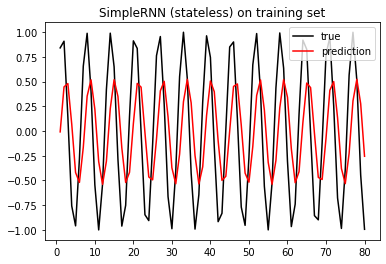

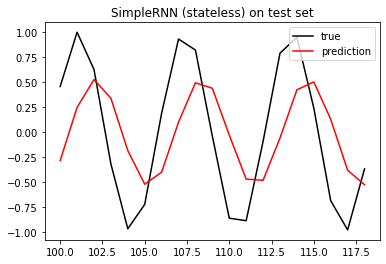

In [19]:
## Plot predictions on traning set
plt.plot(range(1,X_train.shape[0]+1), Y_train, color = 'black', label = 'true')
plt.plot(range(1,X_train.shape[0]+1), pred_srnn_train, color = 'red', label = 'prediction')
plt.title('SimpleRNN (stateless) on training set')
plt.legend()
plt.show()

## Plot predictions on test set
plt.plot(range(100,X_test.shape[0]+100), Y_test, color = 'black', label = 'true')
plt.plot(range(100,X_test.shape[0]+100), pred_srnn_test, color = 'red', label = 'prediction')
plt.title('SimpleRNN (stateless) on test set')
plt.legend()
plt.show()

### Stateful mode
To avoid resetting the states by batches, we need to specify it with `stateful=True`.

In [20]:
# Same model but with stateful 
inputs = keras.Input(batch_shape=(1,1,1))
x = layers.SimpleRNN(5,stateful=True)(inputs) # stateful = True
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# fit the model and make predictions for train and test sets
model.compile(optimizer='rmsprop', 
    loss='mse', 
    metrics=['mae']) 
    
## train stateful LSTM. Reset states by epochs, not by batches
for i in range(100):
	model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
	model.reset_states()


## make predictions
pred_srnn_train = model.predict(X_train, batch_size=1)
pred_srnn_test = model.predict(X_test, batch_size=1)

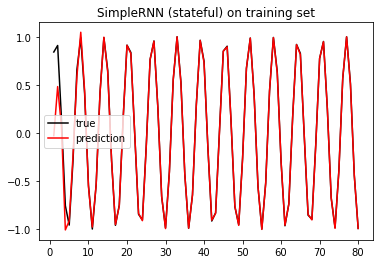

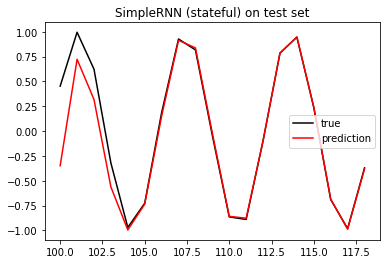

In [21]:
## Plot predictions on traning set
plt.plot(range(1,X_train.shape[0]+1), Y_train, color = 'black', label = 'true')
plt.plot(range(1,X_train.shape[0]+1), pred_srnn_train, color = 'red', label = 'prediction')
plt.title('SimpleRNN (stateful) on training set')
plt.legend()
plt.show()

## Plot predictions on test set
plt.plot(range(100,X_test.shape[0]+100), Y_test, color = 'black', label = 'true')
plt.plot(range(100,X_test.shape[0]+100), pred_srnn_test, color = 'red', label = 'prediction')
plt.title('SimpleRNN (stateful) on test set')
plt.legend()
plt.show()

## Exercise 3
Now fit an LSTM of your choice and plot its predictions on the training and test set against the true values `y`.

In [25]:
inputs = keras.Input(batch_shape=(1,1,1))
x = layers.LSTM(5, stateful=True)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(1, 1, 1)]               0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 5)                    140       
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [26]:
# fit the model and make predictions for train and test sets
model.compile(optimizer='rmsprop', 
    loss='mse', 
    metrics=['mae']) 

## train stateful LSTM
for i in range(100):
	model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
	model.reset_states()


## make predictions
pred_lstm_train = model.predict(X_train, batch_size=1)
pred_lstm_test = model.predict(X_test, batch_size=1)

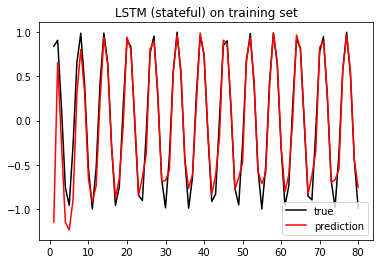

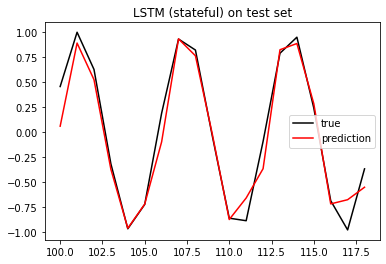

In [27]:
## Plot predictions on traning set
plt.plot(range(1,X_train.shape[0]+1), Y_train, color = 'black', label = 'true')
plt.plot(range(1,X_train.shape[0]+1), pred_lstm_train, color = 'red', label = 'prediction')
plt.title('LSTM (stateful) on training set')
plt.legend()
plt.show()

## Plot predictions on test set
plt.plot(range(100,X_test.shape[0]+100), Y_test, color = 'black', label = 'true')
plt.plot(range(100,X_test.shape[0]+100), pred_lstm_test, color = 'red', label = 'prediction')
plt.title('LSTM (stateful) on test set')
plt.legend()
plt.show()

## Remark
In this setting, the feedforward neural network cannot fully fit the time series. That is because this architecture only uses the past value $y_{t-1}$ to predict $y_{t}$. This is not sufficient, as $y_{t-1}$ does not contain the information of whether the curve is in an increasing or decreasing phase. Using more past information could be helpful. On the other hand, the LSTM fits the time series almost perfectly. This is due to the hidden states of the LSTM, which save information of the previous observations $y_{t-2},y_{t-3},...$ and can provide input as to whether the time series is increasing or decreasing at point $t-1$. 